# Simulations of sampling from a normal distribution

Tong Shu Li

In [1]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as scp

from itertools import product
from math import sqrt
from tqdm import tqdm

In [2]:
np.random.seed(20160427)

In [3]:
%matplotlib inline

## Constant definitions

In [4]:
vals = [
    (2, 10, 2),
    (15, 50, 5),
    (60, 100, 10),
    (120, 500, 20),
    (600, 1000, 100),
    (2000, 15000, 1000)
]

In [5]:
del_var = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

In [6]:
num_samp = []
for start, stop, inc in vals:
    num_samp += [i for i in range(start, stop+inc, inc)]

In [7]:
len(num_samp)

57

In [8]:
# determines curve smoothness
# value determined experimentally
reps = 1000

## Curves under investigation

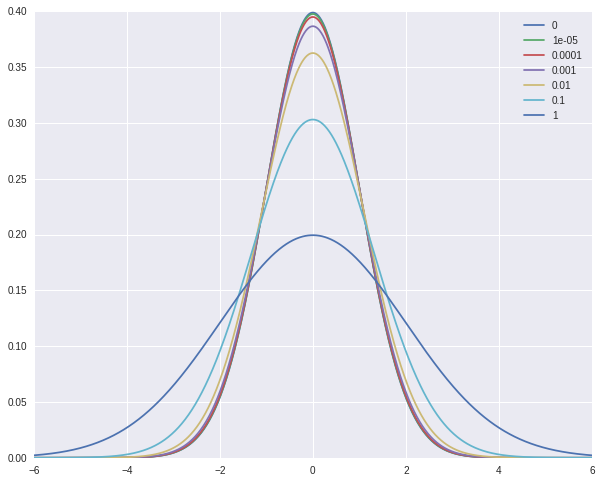

In [9]:
bound = 6
x = np.linspace(-bound, bound, 1000)
plt.figure(figsize = (10, 8))
for var in del_var:
    y = scp.stats.norm.pdf(x, loc = 0, scale = 1 + sqrt(var))
    plt.plot(x, y, label = str(var))
    
plt.legend()
plt.show()  

## Simulation code

In [10]:
def run_trials(vals):
    """Sample N points from two normal distributions with a difference
    in variance of dvar M times.
    
    Return: the test statistic values, as well as the fraction of the times
    the Bartlett's test was significant.
    """
    N, dvar, M = vals
    
    mu = 0
    sigma = 1
    threshold = 0.05
    
    tvals = []
    signif = 0
    for i in range(M):
        a = np.random.normal(mu, sigma, N)
        b = np.random.normal(mu, sigma + sqrt(dvar), N)
        
        t, pval = scp.stats.bartlett(a, b)
        tvals.append(t)
        signif += pval < threshold
        
    return (signif/M, np.median(tvals))

In [11]:
vals = [
    (N, dvar, reps)
    for N, dvar in product(num_samp, del_var)
]

res = []
with mp.Pool(2) as pool:
    for params, ans in zip(vals, tqdm(pool.imap(run_trials, vals), total = len(vals))):
        res.append(params + ans)
        
res = pd.DataFrame(res, columns = ["N", "dvar", "reps", "frac_signif", "median_tval"])

100%|█████████▉| 398/399 [01:28<00:00,  1.26it/s]


In [12]:
res["log_med_tval"] = np.log(res["median_tval"])

In [13]:
res.head()

,N,dvar,reps,frac_signif,median_tval,log_med_tval
0,2,0.00000,1000,0.039,0.440378,-0.820123
1,2,0.00001,1000,0.039,0.439901,-0.821206
2,2,0.00010,1000,0.034,0.439042,-0.823159
3,2,0.00100,1000,0.034,0.443566,-0.812908
4,2,0.01000,1000,0.034,0.513041,-0.667400


Note that running the simulation in parallel produces slightly different results compared to running the simulation serially. However these differences are small and therefore can be effectively ignored.

Thankfully the results are exactly reproducible when the same random seed is used even when the code is run in parallel.

Since running the code in parallel provides around a 2x speed increase, we will continue to use the parallelized version.

## Plot results

In [14]:
def plot_res(res, val_col):
    temp = res.pivot(index = "N", columns = "dvar", values = val_col)

    fig = temp.plot(
        kind = "line",
        figsize = (10, 8)
    )

    fig.legend(
        title = "Delta variance", fontsize = 13,
        loc = "center left", bbox_to_anchor = (1, 0.5)
    )
    
    return fig

## Percent of the time Bartlett's test is significant

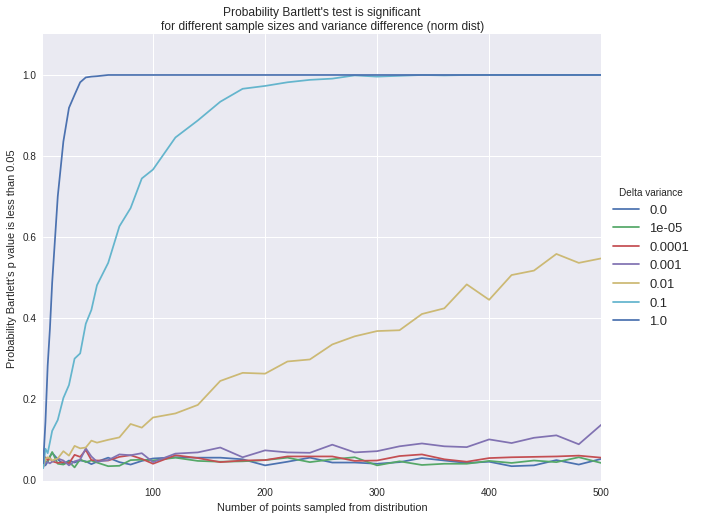

In [15]:
fig = plot_res(res.query("N <= 500"), "frac_signif")

fig.set_title(
    "Probability Bartlett's test is significant\n"
    "for different sample sizes and variance difference (norm dist)"
)

fig.set_xlabel("Number of points sampled from distribution")
fig.set_ylabel("Probability Bartlett's p value is less than 0.05")
fig.set_ylim((0, 1.1));

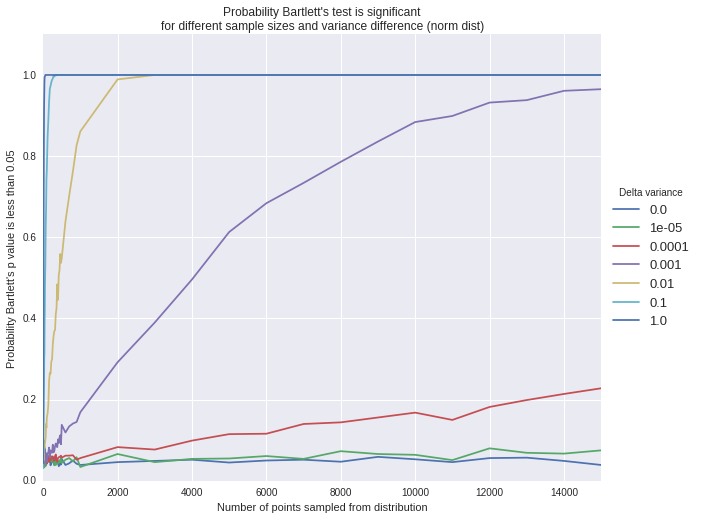

In [16]:
fig = plot_res(res, "frac_signif")

fig.set_title(
    "Probability Bartlett's test is significant\n"
    "for different sample sizes and variance difference (norm dist)"
)

fig.set_xlabel("Number of points sampled from distribution")
fig.set_ylabel("Probability Bartlett's p value is less than 0.05")
fig.set_ylim((0, 1.1));

From these plots we see that Bartlett's test frequently returns a true difference in variance when the sample size is sufficiently large. When the sample size is large enough, any sample will be able to distinguish a true difference in variance between the two distributions.

## Median value of test statistic

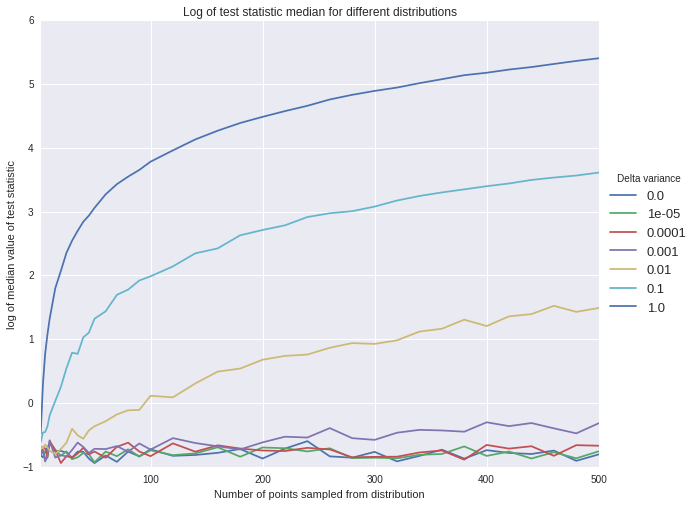

In [17]:
fig = plot_res(res.query("N <= 500"), "log_med_tval")

fig.set_title("Log of test statistic median for different distributions")
fig.set_ylabel("log of median value of test statistic")
fig.set_xlabel("Number of points sampled from distribution");

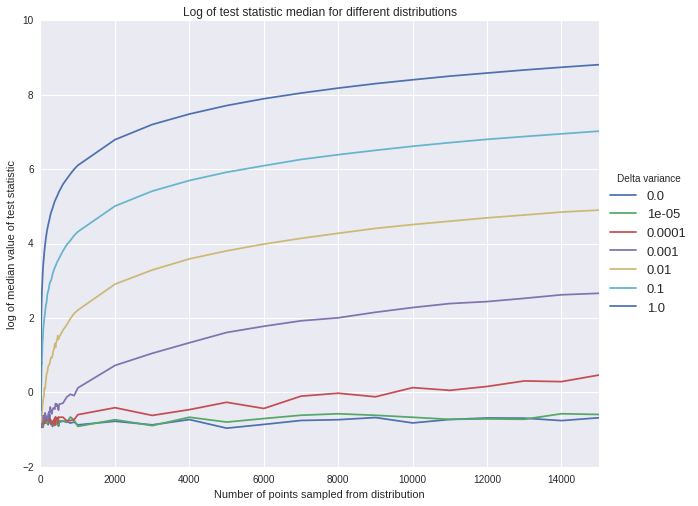

In [18]:
fig = plot_res(res, "log_med_tval")

fig.set_title("Log of test statistic median for different distributions")
fig.set_ylabel("log of median value of test statistic")
fig.set_xlabel("Number of points sampled from distribution");

Based on this we see that the median value of the test statistic increases linearly as the sample size grows. The rate of growth of the test statistic is proportional to the real difference in variance between the two populations.